# Analysis of ddG computation from Rosetta

In [29]:
# His7 is the first residue in the structure
xtal_off = 6

In [2]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import stats as scistats
import numpy as np

In [3]:
# get fasta file from input pdb-structure used for ddG calculations to ensure 
# this will make assert on the merge with PSSM and ddG more secure
!~/bin/pdb_fasta.pl b13Gcat.pdb > b13Gcat.fasta 

In [4]:
# read fasta file
fasta_seq = ""
with open('b13Gcat.fasta','r') as f:
    for line in f:
        if(line[0] == '>'):
            continue
        else:
            fasta_seq += line.strip()
wt_seq = {}
print(len(fasta_seq))
for i in range(len(fasta_seq)):
    wt_seq[str(i+1)] = fasta_seq[i]
    
df_tmp = pd.DataFrame.from_dict(list(wt_seq.items()))
df_wt_seq = df_tmp.rename(columns={0 : 'Pos',1 : 'WT_AA'})
df_wt_seq.info()

276
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
Pos      276 non-null object
WT_AA    276 non-null object
dtypes: object(2)
memory usage: 4.4+ KB


In [5]:
%matplotlib inline

In [6]:
def get_single_letter_AA(residue):
    aa = {
        "ALA" : "A",
        "ILE" : "I",
        "LEU" : "L",
        "VAL" : "V",
        "MET" : "M",
        "PHE" : "F",
        "TYR" : "Y",
        "ARG" : "R",
        "LYS" : "K",
        "TRP" : "W",
        "ASN" : "N",
        "GLN" : "Q",
        "ASP" : "D",
        "GLU" : "E",
        "SER" : "S",
        "THR" : "T",
        "GLY" : "G",
        "PRO" : "P",
        "CYS" : "C",
        "HIS" : "H"
        }
    if(isinstance(residue,str)):
        return aa[residue]
    return "NaN"

In [7]:
def get_stats(group):
    return {'std': np.std(group),'mean': group.mean()}

In [8]:
def get_ddG_monomer_results(path_and_file_name):
    header_text=[
    'COMPLEX:', 'Round', 'Baseline', 'Total Energy', 'fa_atr_label:', 'fa_atr:',
       'fa_rep_label:', 'fa_rep:', 'fa_sol_label:', 'fa_sol:', 'fa_intra_rep_label:', 'fa_intra_rep:',
       'fa_intra_sol_xover4_label:', 'fa_intra_sol_xover4', 'lk_ball_wtd_label:', 'lk_ball_wtd:', 'fa_elec_label:',
       'fa_elec:', 'hbond_sr_bb_label:', 'hbond_sr_bb:', 'hbond_lr_bb_label:', 'hbond_lr_bb:',
       'hbond_bb_sc_label:', 'hbond_bb_sc:', 'hbond_sc_label:', 'hbond_sc:', 'dslf_fa13_label:',
       'dslf_fa13:', 'omega_label:', 'omega:', 'fa_dun_label:', 'fa_dun:', 'p_aa_pp_label:', 'p_aa_pp:',
       'yhh_planarity_label:', 'yhh_planarity:', 'ref_label:', 'ref:', 'rama_prepro_label:', 'rama_prepro:',
       'cart_bonded_label:', 'cart_bonded:'] 
    df = pd.read_csv(path_and_file_name,skiprows=0,delim_whitespace=True,names=header_text)
    return df

In [9]:
# gather data from computation ordinary ddG computation
dfs = []
directory_w_subdirs = './'
filename="mutfile.ddg"
for dr in glob.glob(directory_w_subdirs+"*"):
    if(os.path.isdir(dr) and dr != 'min_cart'):
        try:
            dfs.append(get_ddG_monomer_results(dr+"/"+filename))
        except:
            print("No ddg file present in directory: "+dr)
df_tot = pd.concat(dfs,sort=False)

No ddg file present in directory: ./init
No ddg file present in directory: ./min_cart


In [10]:
df_tot = df_tot.groupby(["Baseline"])["Total Energy"].apply(get_stats).unstack().reset_index()

In [11]:
df_tot.rename(columns={"mean" : "total (mean n=10)", 
                       "std" : "std( total )"},inplace=True)

In [12]:
df_tot["ddG"] = df_tot["total (mean n=10)"] - df_tot["total (mean n=10)"].loc[(df_tot["Baseline"] == "WT:") ].values[0]

In [13]:
df_tot.columns

Index(['Baseline', 'total (mean n=10)', 'std( total )', 'ddG'], dtype='object')

In [14]:
#df_tot["Baseline"].unique()
cutoff = df_tot[df_tot["Baseline"] == "WT:"]['ddG'].values[0]+2*df_tot[df_tot["Baseline"] == "WT:"]['std( total )'].values[0]
print(cutoff)

2.773505135840176


In [15]:
# position and AA
df_tot["Pos"] = df_tot["Baseline"].str.split("_").str[1].str[0:-4]
df_tot["AA"] = df_tot["Baseline"].str.split("_").str[1].str[-4:-1].apply(get_single_letter_AA)

In [16]:
df_tot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 6 columns):
Baseline             5245 non-null object
total (mean n=10)    5245 non-null float64
std( total )         5245 non-null float64
ddG                  5245 non-null float64
Pos                  5244 non-null object
AA                   5245 non-null object
dtypes: float64(3), object(3)
memory usage: 245.9+ KB


Text(0.5,0,'ddG (kcal/mol)')

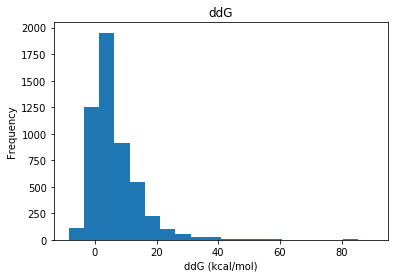

In [17]:
plt.figure();
df_tot["ddG"].plot.hist(bins=20)
plt.title("ddG")
plt.xlabel("ddG (kcal/mol)")

Text(0.5,1,'Distributions of substitutions < 2.77 kcal/mol')

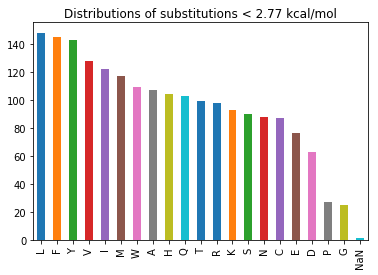

In [18]:
plt.figure()
pd.value_counts(df_tot[df_tot["ddG"] < cutoff]["AA"]).plot.bar()
plt.title("Distributions of substitutions < "+str(round(cutoff,2))+" kcal/mol")

In [19]:
df_tot.rename(columns={"ddG" : "ddG_cart"},inplace=True)

In [20]:
df_tot.head()

,Baseline,total (mean n=10),std( total ),ddG_cart,Pos,AA
0,MUT_100ALA:,-1389.6690,0.000000e+00,9.589402,100,A
1,MUT_100ARG:,-1371.4913,1.218212e+00,27.767102,100,R
2,MUT_100ASN:,-1387.4002,8.623224e-03,11.858202,100,N
3,MUT_100ASP:,-1384.1690,3.070837e-01,15.089402,100,D
4,MUT_100CYS:,-1391.4750,2.273737e-13,7.783402,100,C


In [21]:
df_tot = pd.merge(right=df_wt_seq,right_on="Pos",left=df_tot,left_on="Pos")
df_tot.head()

,Baseline,total (mean n=10),std( total ),ddG_cart,Pos,AA,WT_AA
0,MUT_100ALA:,-1389.6690,0.000000e+00,9.589402,100,A,V
1,MUT_100ARG:,-1371.4913,1.218212e+00,27.767102,100,R,V
2,MUT_100ASN:,-1387.4002,8.623224e-03,11.858202,100,N,V
3,MUT_100ASP:,-1384.1690,3.070837e-01,15.089402,100,D,V
4,MUT_100CYS:,-1391.4750,2.273737e-13,7.783402,100,C,V


In [22]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5244 entries, 0 to 5243
Data columns (total 7 columns):
Baseline             5244 non-null object
total (mean n=10)    5244 non-null float64
std( total )         5244 non-null float64
ddG_cart             5244 non-null float64
Pos                  5244 non-null object
AA                   5244 non-null object
WT_AA                5244 non-null object
dtypes: float64(3), object(4)
memory usage: 327.8+ KB


In [23]:
print(len(df_tot[df_tot["ddG_cart"] < cutoff]["Pos"].unique()))

239


In [24]:
df_tot["AAPos"] = df_tot["Pos"]+df_tot["AA"]
columns_to_file = ["WT_AA","AAPos","Pos","AA","ddG_cart"]
df_tot[columns_to_file].to_csv("20181211_ddG_cart_rosetta_analysis.csv")

In [32]:
# df_tot.sort_values(by="ddG_cart",ascending=True)

In [35]:
df_tot.head(1)

,Baseline,total (mean n=10),std( total ),ddG_cart,Pos,AA,WT_AA,AAPos
0,MUT_100ALA:,-1389.669,0.0,9.589402,100,A,V,100A


In [47]:
# write to pymol pml-file
with open("ddG_positions.pml",'w') as f:
    f.write("show cartoon\n")
    f.write("hide lines\n")
    dftmp = df_tot[df_tot["ddG_cart"] < cutoff]
    for i,j,k in zip(dftmp["WT_AA"],dftmp["Pos"],dftmp["AA"]):
        #try:
        tmppair = i+str(j)+k
        pair="create "+tmppair
        f.write(pair+",resi "+str(int(j)+xtal_off)+"\n" )
        f.write("show sticks, "+str( tmppair )+"\n")
        f.write("color cyan, "+str( tmppair )+" and name C*\n")
        #except:
        #    print("NaN for wt")
    f.write("show lines\nhide everything, elem h")